In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

import plotting as pl

### Read in the data

In [2]:
data = pd.read_csv('data/higgs_data.csv')

higgs_85 = pd.read_csv('data/higgs_higgs_85.csv')
higgs_90 = pd.read_csv('data/higgs_higgs_90.csv')
higgs_95 = pd.read_csv('data/higgs_higgs_95.csv')
eeqq = pd.read_csv('data/higgs_eeqq.csv')
qq = pd.read_csv('data/higgs_qq.csv')
wen = pd.read_csv('data/higgs_wen.csv')
ww = pd.read_csv('data/higgs_ww.csv')
zee = pd.read_csv('data/higgs_zee.csv')
zz = pd.read_csv('data/higgs_zz.csv')


framesMC_NoHiggs = [qq, ww, zz, zee, wen, eeqq]
framesMC_NoHiggsNames = ['qq', 'ww', 'zz', 'zee', 'wen', 'eeqq']

framesMC_HiggsModels = [higgs_85, higgs_90, higgs_95]
framesMC_HiggsModelsNames = ['higgs_85', 'higgs_90', 'higgs_95']


<img src="samples_full.png"> 

### Introduce weights in order to rescale all the MC samples to the same luminosity

per definition the weight of each measured event (data) is $1$. Thus, we want to rescale the MC to the same ntegrated Luminosity of the data taking which is $L = 176.773 \ \mathrm{pb}^{-1}$

The weight for each MC sample is:
$$ 
        \mathrm{weight}_\mathrm{MC} = L \cdot  \frac{\sigma_\mathrm{MC} }{N_\mathrm{MC}}
$$

In [3]:
# load classifier
import cPickle
from sklearn.tree import DecisionTreeClassifier

with open('BDT_85higgs1.pkl', 'rb') as fid:
    BDT_85 = cPickle.load(fid)

with open('BDT_90higgs4.pkl', 'rb') as fid:
    BDT_90 = cPickle.load(fid)

with open('BDT_95higgs3.pkl', 'rb') as fid:
    BDT_95 = cPickle.load(fid)
    
print BDT_85.get_params  
print BDT_90.get_params  
print BDT_95.get_params  


<bound method GradientBoostingClassifier.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=300, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)>
<bound method GradientBoostingClassifier.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.05, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)>
<bound method GradientBoosting

In [4]:
def PickDiscVar_mH85 (df) :
    discriminating_vars = ['btag1','btag2','ucsdbt0','acthm','mvissc','mmis']+['class','weight']
    discriminating_vars = ['ucsdbt0','acthm','mvissc','mmis','xmj1','acop']+['class','weight']
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']
    return df[discriminating_vars]

In [5]:
def KillVars (df) :
    discriminating_vars = [u'btag1', u'btag2',
       u'ucsdbt0', u'mvis', u'mvissc', u'fmvis', u'fmmis', u'fth1',
       u'mmis', u'acthm', u'maxcthj', u'acop', u'maxxov', u'enj1',
       u'thj1', u'phj1', u'xmj1', u'enj2', u'thj2', u'phj2', u'xmj2',
       u'pho_num', u'pho_ene', u'pho_the', u'pho_phi', u'ele_num', u'ele_ene',
       u'ele_the', u'ele_phi', u'muon_num', u'muon_ene', u'muon_the',
       u'muon_phi']+['weight']
    return df[discriminating_vars]

In [6]:
crossSectionsMC_noHiggs = [102., 16.5, 0.975, 3.35, 2.9, 15600.]
NumberMC_noHiggs = [200000., 294500., 196000., 29500., 81786., 5940000.]

crossSectionsMC_HiggsModels = [0.094, 0.0667, 0.0333]
NumberMC_HiggsModels = [3972., 3973., 3971.]


Lum = 176.773


weightsMC_noHiggs     = Lum*np.array(crossSectionsMC_noHiggs) / np.array(NumberMC_noHiggs) 
weightsMC_HiggsModels = Lum*np.array(crossSectionsMC_HiggsModels) / np.array(NumberMC_HiggsModels) 


#add column 'weight' to data frame of all bkg MC
for i, frame in enumerate(framesMC_NoHiggs):
    frame["weight"] = weightsMC_noHiggs[i]
    frame['BDT_selCut85'] = BDT_85.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut90'] = BDT_90.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut95'] = BDT_95.decision_function(PickDiscVar_mH85(df=frame))

#add column 'weight' to data frame of all bkg+sig MC
for i, frame in enumerate(framesMC_HiggsModels):
    frame["weight"] = weightsMC_HiggsModels[i]
    frame['BDT_selCut85'] = BDT_85.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut90'] = BDT_90.decision_function(PickDiscVar_mH85(df=frame))
    frame['BDT_selCut95'] = BDT_95.decision_function(PickDiscVar_mH85(df=frame))

#add column 'weight'=1 to data 
data["weight"] = 1
data['BDT_selCut85'] = BDT_85.decision_function(PickDiscVar_mH85(df=data))
data['BDT_selCut90'] = BDT_90.decision_function(PickDiscVar_mH85(df=data))
data['BDT_selCut95'] = BDT_95.decision_function(PickDiscVar_mH85(df=data))


In [7]:
cut_85 = -3.15
cut_90 = -2.9
cut_95 = -2.9

In [8]:
df_bkg = pd.concat(framesMC_NoHiggs)

In [9]:
data_85 = KillVars(data[data['BDT_selCut85']>cut_85])
data_90 = KillVars(data[data['BDT_selCut90']>cut_90])
data_95 = KillVars(data[data['BDT_selCut95']>cut_95])

sig_85 = KillVars(framesMC_HiggsModels[0][framesMC_HiggsModels[0]['BDT_selCut85']>cut_85])
sig_90 = KillVars(framesMC_HiggsModels[1][framesMC_HiggsModels[1]['BDT_selCut90']>cut_90])
sig_95 = KillVars(framesMC_HiggsModels[2][framesMC_HiggsModels[2]['BDT_selCut95']>cut_95])

bkg_85 = KillVars(df_bkg[df_bkg['BDT_selCut85']>cut_85])
bkg_90 = KillVars(df_bkg[df_bkg['BDT_selCut90']>cut_90])
bkg_95 = KillVars(df_bkg[df_bkg['BDT_selCut95']>cut_95])


In [10]:
# purity in range 90 +- 5 GeV

sig_in_interval = sig_90[(sig_90['mmis']<95)&(sig_90['mmis']>85)]['weight'].sum()
bkg_in_interval = bkg_90[(bkg_90['mmis']<95)&(bkg_90['mmis']>85)]['weight'].sum()

purity = sig_in_interval*1. / bkg_in_interval

print purity
print len(data_90['weight'])

0.397343881101
27


In [11]:
data_85.to_csv('data_85')
data_90.to_csv('data_90')
data_95.to_csv('data_95')

sig_85.to_csv('sig_85')
sig_90.to_csv('sig_90')
sig_95.to_csv('sig_95')

bkg_85.to_csv('bkg_85')
bkg_90.to_csv('bkg_90')
bkg_95.to_csv('bkg_95')

In [12]:
"""signalModelindex = 2

df_MC_noHiggs = pd.concat(framesMC_NoHiggs)
df_MC_mH85 = framesMC_HiggsModels[signalModelindex]
#merge bkg and sig MC
df_mH85 = pd.concat([df_MC_noHiggs,df_MC_mH85])"""

'signalModelindex = 2\n\ndf_MC_noHiggs = pd.concat(framesMC_NoHiggs)\ndf_MC_mH85 = framesMC_HiggsModels[signalModelindex]\n#merge bkg and sig MC\ndf_mH85 = pd.concat([df_MC_noHiggs,df_MC_mH85])'

In [13]:
"""print ('There are ', len(data['weight']), 'data events recorded')

cut = -2.9# -053.4#1.41379310345
print ('There are ', len(data[data['BDT_selCut']>cut]['weight']), 'candidates selected after the cut')"""

"print ('There are ', len(data['weight']), 'data events recorded')\n\ncut = -2.9# -053.4#1.41379310345\nprint ('There are ', len(data[data['BDT_selCut']>cut]['weight']), 'candidates selected after the cut')"

In [14]:
"""# purity in range 90 +- 5 GeV

sig_in_interval = df_MC_mH85[(df_MC_mH85['mmis']<95)&(df_MC_mH85['mmis']>85)&(df_MC_mH85['BDT_selCut']>cut)]['weight'].sum()
bkg_in_interval = df_MC_noHiggs[(df_MC_noHiggs['mmis']<95)&(df_MC_noHiggs['mmis']>85)&(df_MC_noHiggs['BDT_selCut']>cut)]['weight'].sum()

purity = sig_in_interval*1. / bkg_in_interval

print purity"""

"# purity in range 90 +- 5 GeV\n\nsig_in_interval = df_MC_mH85[(df_MC_mH85['mmis']<95)&(df_MC_mH85['mmis']>85)&(df_MC_mH85['BDT_selCut']>cut)]['weight'].sum()\nbkg_in_interval = df_MC_noHiggs[(df_MC_noHiggs['mmis']<95)&(df_MC_noHiggs['mmis']>85)&(df_MC_noHiggs['BDT_selCut']>cut)]['weight'].sum()\n\npurity = sig_in_interval*1. / bkg_in_interval\n\nprint purity"

### distribution of variable of interest

In [15]:
def GetHistogram (df, column, binning) :
  
    return np.histogram(a=df[column],
                        bins = binning,
                        weights=df['weight'])[0]

In [16]:
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

In [43]:
path = '/home/janik/StatMethods/Project/plots/VariableDists/'
ensure_dir(file_path=path)
variable = 'mmis'
x_name = variable
x_unit = 'GeV'
binning = np.array([50,60,70,80,85,90,95,100,105,110,120,140])
binning = np.linspace(50,130,28)
#binning = np.linspace(75,100,28)
save_path = path+variable

In [44]:
"""bkg = np.zeros(len(binning)-1)
for dataframe in framesMC_NoHiggs :
    # do selection cuts    
    bkg += GetHistogram(df=dataframe[dataframe['BDT_selCut']>cut],column=variable,binning=binning)

    
sigModels = [] 
for dataframe in framesMC_HiggsModels :
    
    sigModels.append(GetHistogram(df=dataframe[dataframe['BDT_selCut']>cut],column=variable,binning=binning))
    

data_hist = GetHistogram(df=data[data['BDT_selCut']>cut],column=variable,binning=binning)"""

"bkg = np.zeros(len(binning)-1)\nfor dataframe in framesMC_NoHiggs :\n    # do selection cuts    \n    bkg += GetHistogram(df=dataframe[dataframe['BDT_selCut']>cut],column=variable,binning=binning)\n\n    \nsigModels = [] \nfor dataframe in framesMC_HiggsModels :\n    \n    sigModels.append(GetHistogram(df=dataframe[dataframe['BDT_selCut']>cut],column=variable,binning=binning))\n    \n\ndata_hist = GetHistogram(df=data[data['BDT_selCut']>cut],column=variable,binning=binning)"

In [45]:
bkg_histos = []
sig_histos = []
data_histos = []

for frame in [bkg_85,bkg_90,bkg_95] :
    bkg_histos.append(GetHistogram(df=frame,column=variable,binning=binning))

for frame in [sig_85,sig_90,sig_95] :
    sig_histos.append(GetHistogram(df=frame,column=variable,binning=binning))

for frame in [data_85,data_90,data_95] :
    data_histos.append(GetHistogram(df=frame,column=variable,binning=binning))

    

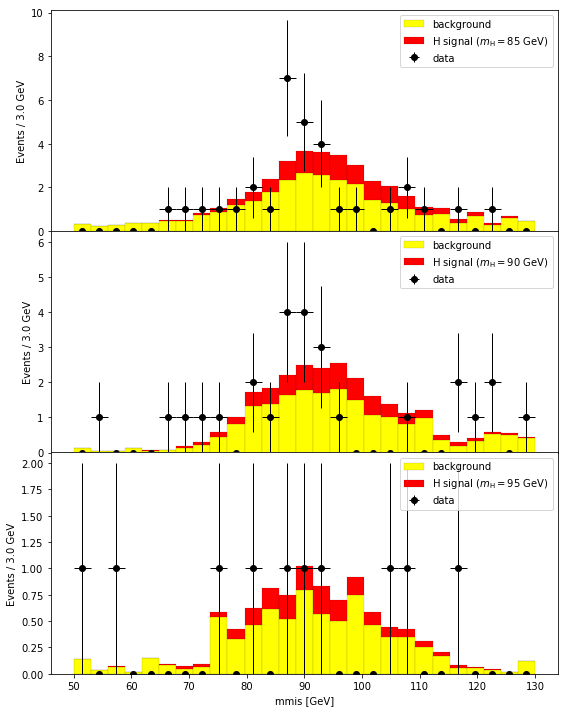

In [47]:
reload(pl)
pl.BkgSigHistos(background=bkg_histos,
                signals=sig_histos,
                data=data_histos,
                variable_binning=binning,
                x_label=[x_name,x_unit],
                savepath=None)#save_path)

In [48]:
"""reload(pl)
pl.BkgSigHistos(background=bkg,signals=sigModels,data=data_hist,variable_binning=binning,
                x_label=[x_name,x_unit],savepath=None)#save_path)"""

'reload(pl)\npl.BkgSigHistos(background=bkg,signals=sigModels,data=data_hist,variable_binning=binning,\n                x_label=[x_name,x_unit],savepath=None)#save_path)'

## The Log-likelihood ratio we define to be

$$
    -2 \log (Q(m_H)) = 2 s_{tot} - 2 \sum_{i=1}^{N_{bins}} N_i \log \left( 1 + \frac{s_i(m_H)}{b_i} \right)
$$

In [49]:
import stats as stat
reload(stat)

<module 'stats' from 'stats.pyc'>

In [50]:
"""Nexp = 10000
llr_85 = stat.LogLikRatio(background=bkg,signal=sigModels[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio(background=bkg,signal=sigModels[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio(background=bkg,signal=sigModels[2],N_experiments=Nexp)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)
"""

Nexp = 10000
llr_85 = stat.LogLikRatio(background=bkg_histos[0],signal=sig_histos[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio(background=bkg_histos[1],signal=sig_histos[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio(background=bkg_histos[2],signal=sig_histos[2],N_experiments=Nexp)

llr_obs_85 = stat.LogLikRatioObserved(background=bkg_histos[0],signals=sig_histos,data=data_histos[0])[0]
llr_obs_90 = stat.LogLikRatioObserved(background=bkg_histos[1],signals=sig_histos,data=data_histos[1])[1]
llr_obs_95 = stat.LogLikRatioObserved(background=bkg_histos[2],signals=sig_histos,data=data_histos[2])[2]

llr_obs = [llr_obs_85,llr_obs_90,llr_obs_95]

In [51]:
path = '/home/janik/StatMethods/Project/plots/loglikeliratio/'
ensure_dir(file_path=path)
save_path = path+variable

In [52]:
print llr_obs

[0.13933493201598779, -1.6663199496940955, -0.40486726723988298]


177
155
182


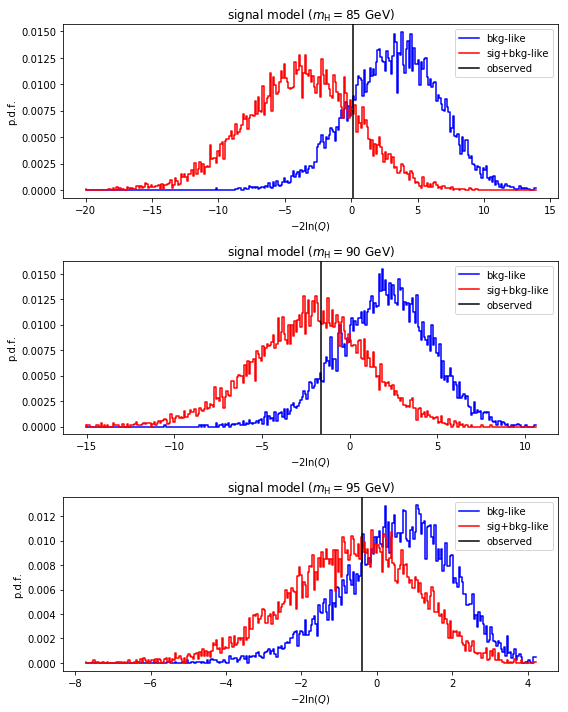

[[0.18030000000000002, 0.17349999999999988], [0.083400000000000016, 0.44540000000000024], [0.23359999999999997, 0.46959999999999996]]


In [126]:
reload(pl)
CLlist, Quantiles_b, Quantiles_sPlusb = pl.LogLikRatioPlots([llr_85,llr_90,llr_95],Nbins=300,obs=llr_obs,savepath=None)#save_path)
print CLlist

$$CL_s = \frac{CL_{s+b}}{CL_b} = \frac{CL_{s+b}}{1-(1-CL_b)}$$

In [127]:
CLs = [entry[1]/(1-entry[0]) for entry in CLlist]
print CLs

print "Confidence level CL >= "
for i in xrange(len(CLs)):
    print "    ", 1 - CLs[i]

[0.21166280346468205, 0.48592624918175897, 0.61273486430062629]
Confidence level CL >= 
     0.788337196535
     0.514073750818
     0.387265135699


# Quantile plot

In [128]:
print Quantiles_b[0]
print Quantiles_b[1]
print Quantiles_b[2]

#print Quantiles_sPlusb

[3.2018824094510023, [-0.32081473924533199, 6.4973087743604765], [-3.9571472798350982, 9.5654643554830905]]
[1.9902740738800464, [-0.76251431302987172, 4.4849885495171602], [-3.6013273370307246, 6.8076537509724044]]
[0.60849629776436664, [-0.91274672266552059, 1.9295757628745314], [-2.6341532984151304, 3.0504916726649736]]


In [142]:
print Quantiles_b[:][0][0]

3.20188240945


In [130]:
MHiggs = np.array([85.,90.,95])

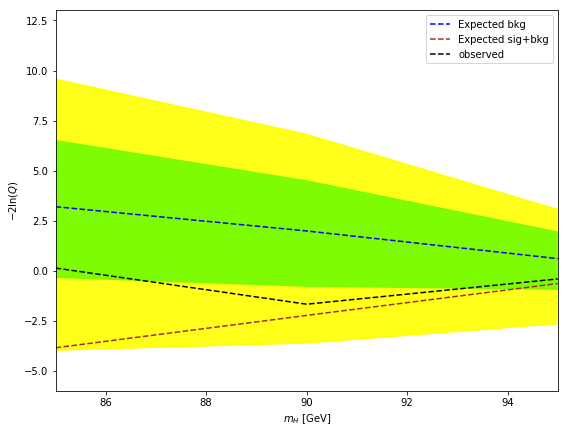

In [161]:
plt.figure(figsize=(9,7))



y_b = np.array([Quantiles_b[0][0],Quantiles_b[1][0],Quantiles_b[2][0]])
y_b_oneS_lower = np.array([Quantiles_b[0][1][0],Quantiles_b[1][1][0],Quantiles_b[2][1][0]])
y_b_oneS_upper = np.array([Quantiles_b[0][1][1],Quantiles_b[1][1][1],Quantiles_b[2][1][1]])


plt.plot(MHiggs,y_b,'b--',label='Expected bkg')


plt.fill_between(MHiggs, y_b_oneS_lower, y_b_oneS_upper,facecolor='lawngreen',alpha=0.99)




plt.plot(MHiggs,[Quantiles_b[0][1][0],Quantiles_b[1][1][0],Quantiles_b[2][1][0]],'y-',color='lawngreen')
plt.plot(MHiggs,[Quantiles_b[0][1][1],Quantiles_b[1][1][1],Quantiles_b[2][1][1]],'y-',color='lawngreen')


y_b_twoS_lower = np.array([Quantiles_b[0][2][0],Quantiles_b[1][2][0],Quantiles_b[2][2][0]])
y_b_twoS_upper = np.array([Quantiles_b[0][2][1],Quantiles_b[1][2][1],Quantiles_b[2][2][1]])

plt.fill_between(MHiggs, y_b_twoS_lower, y_b_oneS_lower,facecolor='yellow',alpha=0.9)
plt.fill_between(MHiggs, y_b_oneS_upper, y_b_twoS_upper,facecolor='yellow',alpha=0.9)


plt.plot(MHiggs,[Quantiles_b[0][2][0],Quantiles_b[1][2][0],Quantiles_b[2][2][0]],'g-',color='yellow')
plt.plot(MHiggs,[Quantiles_b[0][2][1],Quantiles_b[1][2][1],Quantiles_b[2][2][1]],'g-',color='yellow')





plt.plot(MHiggs,[Quantiles_sPlusb[0][0],Quantiles_sPlusb[1][0],Quantiles_sPlusb[2][0]],'--',label='Expected sig+bkg',
        color='brown')


plt.plot(MHiggs,llr_obs,'k--',label='observed')



plt.xlim(85.,95.)
plt.ylim(-6,13)
plt.xlabel(r'$m_{H}$ [GeV]')
plt.ylabel(r'$-2 \ln (Q)$')
plt.legend()
plt.show()

## stuff to try

In [ ]:
b = bkg
s = sigModels[0]
s_tot = s.sum()

llr_b_like = []
llr_sPlusb_like = []
N_exp = 10000

for k in xrange(N_exp) :
    N = np.random.poisson(lam=b)
    llr_b_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))

for k in xrange(N_exp) :
    N = np.random.poisson(lam=(s+b))
    llr_sPlusb_like.append(2*s_tot - 2*np.dot(N,np.log(1+s/b)))
    
    


In [ ]:
plt.hist(llr_b_like,40,color='blue',alpha=0.5,label='bkg-like',normed=True)
plt.hist(llr_sPlusb_like,40,color='red',alpha=0.5,label='sig+bkg-like',normed=True)
plt.xlabel(r'$-2 \log (Q)$')
plt.ylabel('p.d.f.')
plt.legend()
plt.show()


In [276]:
var1 = 'mvis'
var2 = 'btag1'

def GetHistogram_TwoD (df, column1, binning1, column2, binning2) :
  
    return np.histogram2d(df[column1],
                        df[column2],
                        bins = [binning1,binning2],
                        weights=df['weight'],
                         normed=True)[0]

bkg = np.zeros((len(var_dict[var1]['binning'])-1, len(var_dict[var2]['binning'])-1))
for dataframe in framesMC_NoHiggs :
    bkg += GetHistogram_TwoD(df=dataframe,
                             column1=var1,binning1=var_dict[var1]['binning'],
                             column2=var2,binning2=var_dict[var2]['binning'])

sigModels = [] 
for dataframe in framesMC_HiggsModels :
    sigModels.append(GetHistogram_TwoD(df=dataframe,
                             column1=var1,binning1=var_dict[var1]['binning'],
                             column2=var2,binning2=var_dict[var2]['binning']))
    

data_hist = GetHistogram_TwoD(df=data,
                             column1=var1,binning1=var_dict[var1]['binning'],
                             column2=var2,binning2=var_dict[var2]['binning'])

for dataframe in framesMC_HiggsModels :
    plt.hist2d(dataframe[var1],
                        dataframe[var2],
                        bins = [var_dict[var1]['binning'],var_dict[var2]['binning']],
                        weights=dataframe['weight'])
    plt.show()
for dataframe in framesMC_NoHiggs :
    plt.hist2d(dataframe[var1],
                        dataframe[var2],
                        bins = [var_dict[var1]['binning'],var_dict[var2]['binning']],
                        weights=dataframe['weight'])
    plt.show()

KeyError: 'btag1'

In [266]:
Nexp = 10000
llr_85 = stat.LogLikRatio_TwoD(background=bkg,signal=sigModels[0],N_experiments=Nexp)
llr_90 = stat.LogLikRatio_TwoD(background=bkg,signal=sigModels[1],N_experiments=Nexp)
llr_95 = stat.LogLikRatio_TwoD(background=bkg,signal=sigModels[2],N_experiments=Nexp)

llr_obs = stat.LogLikRatioObserved(background=bkg,signals=sigModels,data=data_hist)

In [273]:
#print llr_obs
#print llr_85
print bkg
print sigModels[0]

[[  0.00000000e+00   0.00000000e+00   4.68422706e-06   7.45420492e-04]
 [  0.00000000e+00   0.00000000e+00   6.86154736e-04   2.89343998e-03]
 [  0.00000000e+00   1.31592128e-03   4.42380136e-03   1.17387045e-03]
 [  5.98643192e-04   4.84934104e-03   3.30872325e-03   0.00000000e+00]]
[[  0.00000000e+00   0.00000000e+00   1.00857287e-06   3.12657590e-05]
 [  0.00000000e+00   0.00000000e+00   1.18003026e-04   2.80383258e-04]
 [  0.00000000e+00   1.85577408e-04   1.51285930e-03   7.66515381e-05]
 [  1.71457388e-05   8.51235502e-04   2.59203227e-04   0.00000000e+00]]


In [ ]:
bkg = GetHistogram(qq,column=variable,binning=binning)

In [ ]:
print(len(binning))
print(len(bkg))

print(binning)
print(bkg)
binw = binning[1]-binning[0]
plt.bar(binning[:-1]+binw/2.,bkg,width=binw)
plt.show()

In [ ]:
a = qq.groupby(variable)['weight'].sum()

plt.hist(a)
plt.show()

In [239]:
a = np.array([[1,2],[3,4]])
b = np.array([[1,2],[3,100]])
print np.sum(a*b)

414


In [ ]:
for col in qq.columns :
    print(col)

In [ ]:
for col in data :
    print(col)